In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import re
import sys
sys.path.append('../../util/')
import sgt
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy import spatial
from scipy.stats import entropy
from numpy.linalg import norm

### Create corpus from the same author and same-size random sample

In [3]:
df = pd.read_csv('../../data/shakespare_william_works_preprocessed.tsv', sep = '\t')

In [4]:
df_au_cnt = pd.DataFrame(df['Author'].value_counts())

In [5]:
au_list = []
for i in range(10):
    au_list.append(random.choice(df_au_cnt[df_au_cnt['Author'] > 5].index.tolist()))

In [6]:
au_list

['Astray',
 'AuburnRed',
 'JLR',
 'fog_shadow',
 'grxntxire',
 'NEStar',
 'orphan_account',
 'betony',
 'yuletide_archivist',
 'LocalSarcasm']

In [7]:
df_all = []
df_rand_dict = {}
for au in au_list:
    df_Au = df[df.Author == au]
    df_all.append(df_Au)
    df_Rand = df.sample(len(df_Au))
    df_all.append(df_Rand)
    df_rand_dict[au] = df_Rand    
df_all = pd.concat(df_all)

### General functions

In [8]:
# create a corpus to give to sklearn
def create_corpus_for_voc(df):
    doc = []
    for i in df.Text.tolist():
        #Remove some non-ascii characters and 'aa's
        i = re.sub(r'aA|aa', 'a', i)
        i = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', i)
        i = i.lower()
        doc.append(i)  
    return doc

In [9]:
# Get a vocabulary using sklearn's filtering
def get_voc(corpus, ngram, mindf):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(ngram,ngram),min_df=mindf)
    f = vectorizer.fit_transform(corpus)
    return set(sorted(vectorizer.get_feature_names()))

In [10]:
def bootstrap_resample(li):
    if len(li) > 0:
        ave_original = np.average(li)
        aves = []
        for i in range(1000):
            sample = []
            for i in range(len(li)):
                sample.append(random.choice(li))
            aves.append(np.average(sample))
        tail = sorted(aves)[24]
        head = sorted(aves)[975]
        return (ave_original, tail, head)

In [11]:
def process_sentence(sentence):
    # input: sentence as a string
    # output: a list of words in the sentence
    sentence = re.sub(r'aA|aa', 'a', sentence)
    sentence = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', sentence).lower()
    sentence = re.findall(u'(?u)\\b\\w\\w+\\b', sentence)
    return sentence

In [12]:
def calc_results(au_dist,rand_dist):
    results_au = []
    results_rand = []
    for i in range(len(au_dist)):
        for j in range(i, len(au_dist)):
            results_au.append(spatial.distance.cosine(au_dist[i], au_dist[j]))
    results_au = bootstrap_resample(results_au)
    for i in range(len(rand_dist)):
        for j in range(i, len(rand_dist)):
            results_rand.append(spatial.distance.cosine(rand_dist[i], rand_dist[j]))
    results_rand = bootstrap_resample(results_rand)
    return results_au, results_rand

In [13]:
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [14]:
def calc_results_jsd(au_dist,rand_dist):
    results_au = []
    results_rand = []
    for i in range(len(au_dist)):
        for j in range(i, len(au_dist)):
            results_au.append(JSD(au_dist[i], au_dist[j]))
    results_au = bootstrap_resample(results_au)
    for i in range(len(rand_dist)):
        for j in range(i, len(rand_dist)):
            results_rand.append(JSD(rand_dist[i], rand_dist[j]))
    results_rand = bootstrap_resample(results_rand)
    return results_au, results_rand

### Unigram + no smoothing

In [15]:
# compute unigram-frequency dict using the same preprocessing, using only words from the vocabulary
def create_unigram_freq_dict(df, voc):
    text = []
    df_text = df['Text'].tolist()
    for line in df_text:
        line = process_sentence(line)
        text.extend(line)
    text = map(lambda x:x if x in voc else None, text)
    text = dict(Counter(text))
    return text

In [16]:
def prob_score(vocab, sentence, unifreq):
    unisize = len(unifreq)
    prob = []
    sentence = process_sentence(sentence)
    for word in vocab:
        if word in sentence:
            prob.append(unifreq.get(word, 0)/unisize)
        else:
            prob.append(0)
    return prob

In [17]:
corpus = create_corpus_for_voc(df_all)
univocab = get_voc(corpus, 1, 1)
unidict = create_unigram_freq_dict(df_all, univocab)

In [18]:
results_au_all = [0,0,0]
results_rand_all = [0,0,0]

for au in au_list:
    df_Au = df[df.Author == au]
    df_Au['Dist'] = df_Au['Text'].map(lambda x: prob_score(univocab, x, unidict))
    au_dist = df_Au['Dist'].tolist()

    df_Rand = df_rand_dict[au]
    df_Rand['Dist'] = df_Rand['Text'].map(lambda x: prob_score(univocab, x, unidict))
    rand_dist = df_Rand['Dist'].tolist()
    
    results_au, results_rand = calc_results_jsd(au_dist,rand_dist)
    results_au_all[0] += results_au[0]
    results_au_all[1] += results_au[1]
    results_au_all[2] += results_au[2]
    results_rand_all[0] += results_rand[0]
    results_rand_all[1] += results_rand[1]
    results_rand_all[2] += results_rand[2]
    

results_au_all[0] = results_au_all[0]/len(au_list)
results_au_all[1] = results_au_all[1]/len(au_list)
results_au_all[2] = results_au_all[2]/len(au_list)
results_rand_all[0] = results_rand_all[0]/len(au_list)
results_rand_all[1] = results_rand_all[1]/len(au_list)
results_rand_all[2] = results_rand_all[2]/len(au_list)

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
print(results_au_all,results_rand_all)

[0.35293504298383621, 0.31654194552571913, 0.38528981756401942] [0.37844145322657041, 0.33627186751614874, 0.41794775616744373]


### Unigram + Good-Turing smoothing

In [20]:
def create_unigram_freq_dict(df, voc):
    text = {}
    df_text = df.Text.tolist()
    for line in df_text:
        line_f = process_sentence(line)
        line_f = [word for word in line_f if word in voc]
        text[line] = dict(Counter(line_f))
    return text

In [21]:
def get_dist(text, di, vocab):
    prob_line = []
    sgt_line = sgt.simpleGoodTuringProbs(di[text])
    num_abs_words = len(vocab - set(di[text].keys()))
    for word in vocab:
        if word in di[text].keys():
            prob_line.append(sgt_line[0][word])
        else:
            prob_line.append(sgt_line[1]/float(num_abs_words))
    return prob_line
#     except:
#         return [0]

In [22]:
corpus = create_corpus_for_voc(df_all)
univocab = get_voc(corpus, 1, 1)
unidict = create_unigram_freq_dict(df_all, univocab)

In [23]:
results_au_all_2 = [0,0,0]
results_rand_all_2 = [0,0,0]

for au in au_list:
    df_Au = df[df.Author == au]
    df_Au['Dist'] = df_Au['Text'].map(lambda x: get_dist(x, unidict, univocab))
    au_dist = df_Au['Dist'].tolist()

    df_Rand = df_rand_dict[au]
    df_Rand['Dist'] = df_Rand['Text'].map(lambda x: get_dist(x, unidict, univocab))
    rand_dist = df_Rand['Dist'].tolist()
    
    results_au, results_rand = calc_results_jsd(au_dist,rand_dist)
    results_au_all_2[0] += results_au[0]
    results_au_all_2[1] += results_au[1]
    results_au_all_2[2] += results_au[2]
    results_rand_all_2[0] += results_rand[0]
    results_rand_all_2[1] += results_rand[1]
    results_rand_all_2[2] += results_rand[2]
    

results_au_all_2[0] = results_au_all_2[0]/len(au_list)
results_au_all_2[1] = results_au_all_2[1]/len(au_list)
results_au_all_2[2] = results_au_all_2[2]/len(au_list)
results_rand_all_2[0] = results_rand_all_2[0]/len(au_list)
results_rand_all_2[1] = results_rand_all_2[1]/len(au_list)
results_rand_all_2[2] = results_rand_all_2[2]/len(au_list)

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
print(results_au_all_2,results_rand_all_2 )

[0.16115418568008127, 0.14370050194312936, 0.17764297024189055] [0.22030305319738175, 0.19795286001959006, 0.24127330359129293]


### bigram + Stupid backoff

In [25]:
# compute unigram-frequency dict using the same preprocessing, using only words from the vocabulary
def create_unigram_freq_dict(df, voc):
    text = []
    df_text = df.Text.tolist()
    for line in df_text:
        line_f = process_sentence(line)
        text.extend(line_f)
    text = map(lambda x:x if x in voc else None, text)
    text = dict(Counter(text))
    return text


In [26]:
def create_bigram_freq_dict(df, voc):
    text = []
    df_text = df.Text.tolist()
    for line in df_text:
        line_f = re.sub(r'aA|aa', 'a', line)
        line_f = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', line_f).lower()
        line_f = re.findall(u'(?u)\\b\\w\\w+\\b', line_f)
        text.extend(line_f)
    text_bi = []
    for i in range(len(text)-1):
        text_bi.append(text[i]+' '+text[i+1]) 
    text_bi = map(lambda x:x if x in voc else None, text_bi)
    text_bi = dict(Counter(text_bi))
    return text_bi

In [27]:
# Stupid backoff. If bigram is in dictionary, score = freq/size.
# If not, go back to unigram, score = 0.4*unigram/size.

def calc_sb(bigram, bifreq, unifreq):
    if bifreq.get(bigram):
        return float(bifreq.get(bigram))/len(bifreq)
    else:
        uni = bigram.split(' ')[1]
        return float(0.4*unifreq.get(uni, 0))/len(unifreq)

In [28]:
def sb_score(bivocab, sentence, unifreq, bifreq):
    bigrams = []

    sentence = re.sub(r'aA|aa', 'a', sentence)
    sentence = re.sub(r'\\xe2........|\\xc|\\xa|\\n|[0123456789*_]', '', sentence).lower()
    sentence = re.findall(u'(?u)\\b\\w\\w+\\b', sentence)
    for i in range(len(sentence)-1):
        bigrams.append(sentence[i]+' '+sentence[i+1]) 

    prob = list(map(lambda x: calc_sb(x, bifreq, unifreq) if x in bigrams else 0, bivocab))

    return prob

In [29]:
corpus = create_corpus_for_voc(df_all)
univocab = get_voc(corpus, 1,1)
unidict = create_unigram_freq_dict(df_all, univocab)
bivocab = get_voc(corpus,2,1)
bidict = create_bigram_freq_dict(df_all, bivocab)

In [30]:
results_au_all_3 = [0,0,0]
results_rand_all_3 = [0,0,0]
for au in au_list:
    df_Au = df[df.Author == au]
    df_Rand = df_rand_dict[au]
    
    df_Au['Dist'] = df_Au['Text'].map(lambda x: sb_score(bivocab, x, unidict, bidict))
    au_dist = df_Au['Dist'].tolist()

    df_Rand['Dist'] = df_Rand['Text'].map(lambda x: sb_score(bivocab, x, unidict, bidict))
    rand_dist = df_Rand['Dist'].tolist()
    
    results_au, results_rand = calc_results_jsd(au_dist,rand_dist)
    results_au_all_3[0] += results_au[0]
    results_au_all_3[1] += results_au[1]
    results_au_all_3[2] += results_au[2]
    results_rand_all_3[0] += results_rand[0]
    results_rand_all_3[1] += results_rand[1]
    results_rand_all_3[2] += results_rand[2]
    

results_au_all_3[0] = results_au_all_3[0]/len(au_list)
results_au_all_3[1] = results_au_all_3[1]/len(au_list)
results_au_all_3[2] = results_au_all_3[2]/len(au_list)
results_rand_all_3[0] = results_rand_all_3[0]/len(au_list)
results_rand_all_3[1] = results_rand_all_3[1]/len(au_list)
results_rand_all_3[2] = results_rand_all_3[2]/len(au_list)

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
print(results_au_all_3,results_rand_all_3 )

[0.54993509704506782, 0.49732690365341237, 0.59778409928982967] [0.58519413149015154, 0.53156174419394742, 0.63501826922754834]


In [37]:
def plt_multiple(l1_au,l1_rand,l2_au,l2_rand,l3_au,l3_rand):
    plt.figure(figsize=(13,4))
    plt.subplot(1, 3, 1)
    lower_error1 = [l1_au[0] - l1_au[1]]
    upper_error1 = [l1_au[2] - l1_au[0]]
    lower_error2 = [l1_rand[0] - l1_rand[1]]
    upper_error2 = [l1_rand[2] - l1_rand[0]]

    asymmetric_error1 =[lower_error1,lower_error2 ]
    asymmetric_error2 =[upper_error1, upper_error2]
    p1 = [1, 2]
    p2 = [l1_au[0], l1_rand[0]]

    plt.errorbar(p1, p2, yerr=[asymmetric_error1, asymmetric_error2],fmt='o')
    plt.xlim(0.5,2.5)
    plt.ylim(0,1)
    plt.legend(loc='lower right')
    plt.xticks(p1, ['Same author', 'Multiple authors'])
    plt.ylabel('Unigram + no smoothing', fontsize = 14)

    plt.subplot(1, 3, 2)
    lower_error1 = [l2_au[0] - l2_au[1]]
    upper_error1 = [l2_au[2] - l2_au[0]]
    lower_error2 = [l2_rand[0] - l2_rand[1]]
    upper_error2 = [l2_rand[2] - l2_rand[0]]

    asymmetric_error1 =[lower_error1,lower_error2 ]
    asymmetric_error2 =[upper_error1, upper_error2]
    p1 = [1, 2]
    p2 = [l2_au[0], l2_rand[0]]

    plt.errorbar(p1, p2, yerr=[asymmetric_error1, asymmetric_error2],fmt='o')
    plt.xlim(0.5,2.5)
    plt.ylim(0,1)
    plt.legend(loc='lower right')
    plt.xticks(p1, ['Same author', 'Multiple authors'])
    plt.ylabel('Unigram + Good-Turing smoothing', fontsize = 14)

    plt.subplot(1, 3, 3)
    lower_error1 = [l3_au[0] - l3_au[1]]
    upper_error1 = [l3_au[2] - l3_au[0]]
    lower_error2 = [l3_rand[0] - l3_rand[1]]
    upper_error2 = [l3_rand[2] - l3_rand[0]]

    asymmetric_error1 =[lower_error1,lower_error2 ]
    asymmetric_error2 =[upper_error1, upper_error2]
    p1 = [1, 2]
    p2 = [l3_au[0], l3_rand[0]]

    plt.errorbar(p1, p2, yerr=[asymmetric_error1, asymmetric_error2],fmt='o')
    plt.xlim(0.5,2.5)
    plt.ylim(0,1)
    plt.legend(loc='lower right')
    plt.xticks(p1, ['Same author', 'Multiple authors'])
    plt.ylabel('Bigram + Stupid backoff', fontsize = 14)

    plt.savefig('comparison_ngram_10au_jsd_2.pdf', type='pdf')

/Users/jingy/anaconda/envs/python35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


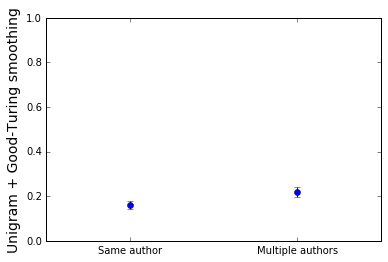

In [38]:
plt_multiple(results_au_all_2,results_rand_all_2)